# About

I reused my notebook in Tabular Playground Series - Jan 2021:  
https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline

<br>

* GBDT Models baseline
    * LightGBM, XGBoost, CatBoost
    * each model is trained by 5 folds cross validation 


* feature engineering
    * **label-encoding** for category features
    * no feature engineering for continuous features


* inference test by weighted averaging 3 GBDT Models(5 folds averaging)

<br>

There is a lot of room for improvement such as feature engineering, parameter tuning, other models, and so on. enjoy ;) 


# Prepare

## import libraries

In [114]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [115]:
np.log2(244)

7.930737337562887

## read data

In [116]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
smpl_sub = pd.read_csv('..\\kaggle_data\\sample_submission.csv')
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (300000, 26), test: (200000, 25), sample sub: (200000, 2)


In [118]:
train = train[(np.abs(stats.zscore(train['target'])) < 3.0)]
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (299573, 26), test: (200000, 25), sample sub: (200000, 2)


In [119]:
train.head().T

,0,1,2,3,4
id,1,2,3,4,6
cat0,A,B,A,A,A
cat1,B,A,A,A,B
cat2,A,A,A,A,A
cat3,A,A,C,C,A
cat4,B,B,B,B,B
cat5,D,B,D,D,B
cat6,A,A,A,A,A
cat7,E,E,B,E,E
cat8,C,A,C,G,C


## Definition

In [120]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [121]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = None,
              cat_cols: list = None,
            ):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(
                X_train, label=y_train, cat_features=cat_cols)  #, group_id=[0] * len(X_train))
            self.val_data = Pool(
                X_val, label=y_val, cat_features=cat_cols)  #, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

## Config 

In [122]:
ID_COL = "id"
CAT_COLS= [f"cat{i}" for i in range(10)]
CONT_COLS = [f"cont{i}" for i in range(14)]
TGT_COL = "target"

N_SPLITS = 5
RANDOM_SEED_LIST = [
    42,
#     2021, 0, 1086, 39
]

MODEL_PARAMS = {
    "lgb": {
        "objective": "root_mean_squared_error",
        "boosting": "gbdt",
        "max_depth": 8,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "subsample_freq": 6,
        "reg_alpha": 6,
        "min_data_in_leaf": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        # "device": "gpu",
        # "gpu_device_id": 0
    },
    "xgb": {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    },
    "cat": {
        'loss_function': 'RMSE',
        "max_depth": 4,
        'learning_rate': 0.05,
        "colsample_bylevel": 0.4,
        "subsample": 0.6,
        "min_child_samples": 100, 
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
#         "task_type": "GPU",
#         "devices" : "0",
        'num_boost_round': 20000,
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 200,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval":  200,
    },
    "cat": {
        'early_stopping_rounds': 200,
        'verbose_eval': 200,
    }
}

## Feature Engineering

In [123]:
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()

### for categorical features

apply label encoding using [`category_encoders.OrdinalEncoder`](https://contrib.scikit-learn.org/category_encoders/ordinal.html)

In [124]:
ord_enc = ce.OrdinalEncoder(cols=CAT_COLS)
train_cat_feat = ord_enc.fit_transform(train[CAT_COLS])
test_cat_feat = ord_enc.transform(test[CAT_COLS])

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [125]:
train_feat = pd.concat([
    train_feat, train_cat_feat], axis=1)
test_feat = pd.concat([
    test_feat, test_cat_feat], axis=1)
use_feat_cols.extend(train_cat_feat.columns)

### for continuous features

Use them as they are

In [126]:
train_cont_feat = train[CONT_COLS]
test_cont_feat = test[CONT_COLS]

In [127]:
train_feat = pd.concat([
    train_feat, train_cont_feat], axis=1)
test_feat = pd.concat([
    test_feat, test_cont_feat], axis=1)
use_feat_cols.extend(CONT_COLS)

In [128]:
train_feat.head().T

,0,1,2,3,4
id,1.000000,2.000000,3.000000,4.000000,6.000000
cat0,1.000000,2.000000,1.000000,1.000000,1.000000
cat1,1.000000,2.000000,2.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,1.000000,1.000000
cat3,1.000000,1.000000,2.000000,2.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,2.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,2.000000,1.000000,1.000000
cat8,1.000000,2.000000,1.000000,3.000000,1.000000


In [129]:
test_feat.head().T

,0,1,2,3,4
id,0.000000,5.000000,15.000000,16.000000,17.000000
cat0,1.000000,1.000000,1.000000,1.000000,1.000000
cat1,1.000000,1.000000,1.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,2.000000,1.000000
cat3,2.000000,2.000000,2.000000,1.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,1.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,1.000000,1.000000,1.000000
cat8,4.000000,1.000000,1.000000,4.000000,4.000000


## Training

In [130]:
def run_train_and_inference(
    X, X_test, y, use_model, model_params, train_params, seed_list, n_splits, cat_cols=None
):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params, cat_cols=cat_cols
                )
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

In [131]:
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (299573, 24), test_feat: (200000, 24)


### LightGBM

In [132]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([  1228,   3111,   3166,   3338,   3882,\n            ...\n            291693, 294302, 296712, 298257, 299129],\n           dtype='int64', length=337). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [90]:
score_lgb
np.save('lgb',)

,seed,fold,rmse score
0,42,0,0.848613
1,42,1,0.846330
2,42,2,0.850002
3,42,3,0.847526
4,42,4,0.846372
5,42,5,0.844328
6,42,6,0.848095
7,42,oof,0.847325
8,avg,oof,0.847325


In [91]:
score_lgb.loc[score_lgb.fold == "oof"]

,seed,fold,rmse score
7,42,oof,0.847325
8,avg,oof,0.847325


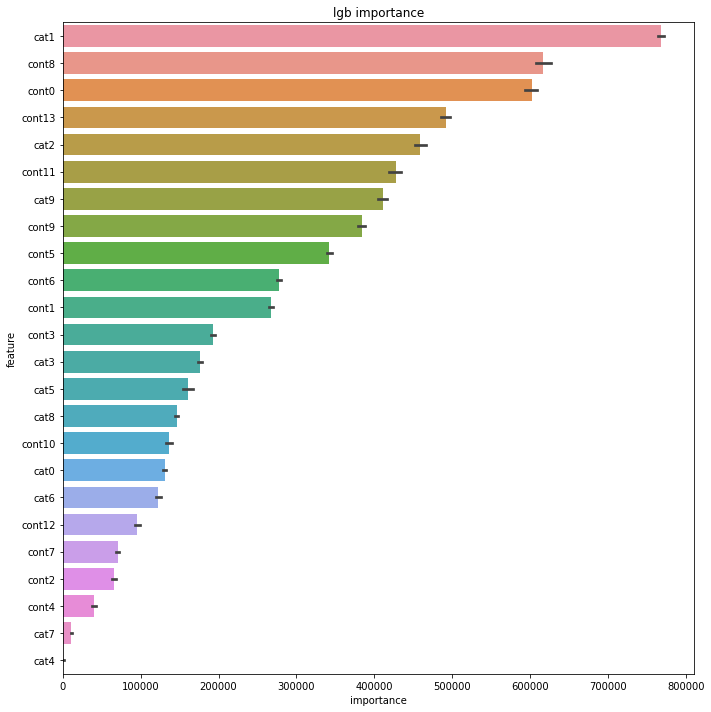

In [92]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

### XGBoost

In [93]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
[0]	train-rmse:7.00597	val-rmse:7.00421
[200]	train-rmse:5.75755	val-rmse:5.75582
[400]	train-rmse:4.74016	val-rmse:4.73847
[600]	train-rmse:3.91281	val-rmse:3.91119
[800]	train-rmse:3.24205	val-rmse:3.24054
[1000]	train-rmse:2.70061	val-rmse:2.69927
[1200]	train-rmse:2.26623	val-rmse:2.26508
[1400]	train-rmse:1.92062	val-rmse:1.91973
[1600]	train-rmse:1.64865	val-rmse:1.64805
[1800]	train-rmse:1.43758	val-rmse:1.43733
[2000]	train-rmse:1.27647	val-rmse:1.27659
[2200]	train-rmse:1.15563	val-rmse:1.15616
[2400]	train-rmse:1.06673	val-rmse:1.06769
[2600]	train-rmse:1.00244	val-rmse:1.00381
[2800]	train-rmse:0.95662	val-rmse:0.95838
[3000]	train-rmse:0.92437	val-rmse:0.92650
[3200]	train-rmse:0.90180	val-rmse:0.90426
[3400]	train-rmse:0.88609	val-rmse:0.88886
[3600]	train-rmse:0.87514	val-rmse:0.87819
[3800]	train-rmse:0.86749	val-rmse:0.87079
[4000]	train-rmse:0.86209	v

In [94]:
score_xgb

,seed,fold,rmse score
0,42,0,0.849890
1,42,1,0.847586
2,42,2,0.851167
3,42,3,0.848919
4,42,4,0.847709
5,42,5,0.845734
6,42,6,0.849221
7,42,oof,0.848605
8,avg,oof,0.848605


In [95]:
score_xgb.loc[score_xgb.fold == "oof"]

,seed,fold,rmse score
7,42,oof,0.848605
8,avg,oof,0.848605


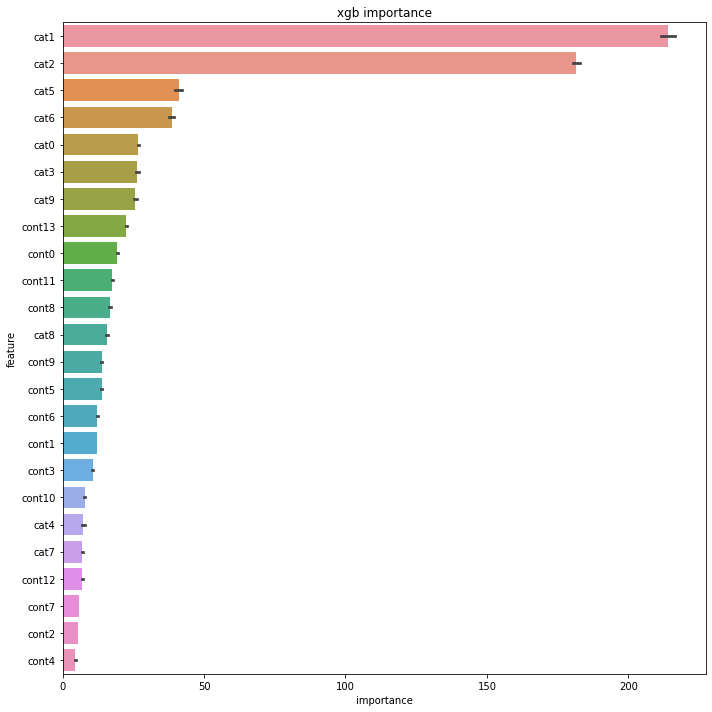

In [96]:
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

In [97]:
#train = train[(np.abs(stats.zscore(train['target'])) < 3.0)]

### CatBoost

In [98]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 42 - Fold: 0
0:	learn: 0.8867923	test: 0.8897816	best: 0.8897816 (0)	total: 33.6ms	remaining: 4m 12s
200:	learn: 0.8729744	test: 0.8758535	best: 0.8758535 (200)	total: 6.02s	remaining: 3m 38s
400:	learn: 0.8669618	test: 0.8696582	best: 0.8696582 (400)	total: 12s	remaining: 3m 31s
600:	learn: 0.8631566	test: 0.8657167	best: 0.8657167 (600)	total: 18s	remaining: 3m 26s
800:	learn: 0.8604606	test: 0.8628759	best: 0.8628759 (800)	total: 23.8s	remaining: 3m 19s
1000:	learn: 0.8584152	test: 0.8607701	best: 0.8607701 (1000)	total: 29.8s	remaining: 3m 13s
1200:	learn: 0.8568531	test: 0.8591286	best: 0.8591286 (1200)	total: 35.6s	remaining: 3m 6s
1400:	learn: 0.8556117	test: 0.8578590	best: 0.8578590 (1400)	total: 41.6s	remaining: 3m 1s
1600:	learn: 0.8545843	test: 0.8568219	best: 0.8568219 (1600)	total: 47.4s	remaining: 2m 54s
1800:	learn: 0.8537188	test: 0.8559643	best: 0.8559643 (1800)	

In [99]:
score_cat

,seed,fold,rmse score
0,42,0,0.847220
1,42,1,0.844964
2,42,2,0.849136
3,42,3,0.846454
4,42,4,0.844992
5,42,5,0.843140
6,42,6,0.846711
7,42,oof,0.846090
8,avg,oof,0.846090


In [100]:
score_cat.loc[score_cat.fold == "oof"]

,seed,fold,rmse score
7,42,oof,0.84609
8,avg,oof,0.84609


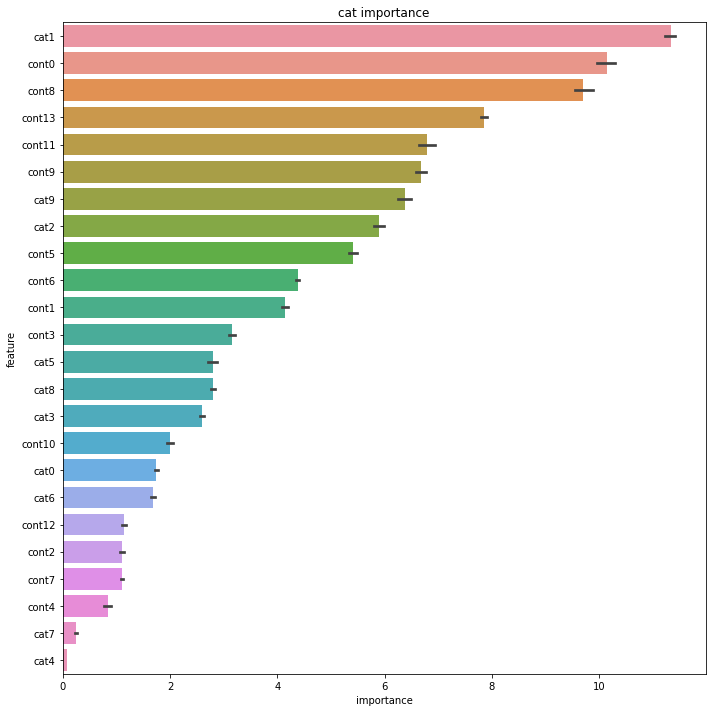

In [101]:
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

### Ensemble LGB, XGB, Cat

### check correlation

In [102]:
model_names = ["lgb", "xgb", "cat"]

In [103]:
# # prediction for oof
pd.DataFrame(
    np.corrcoef([
        oof_pred_lgb,
        oof_pred_xgb,
        oof_pred_cat
    ]),
    columns=model_names, index=model_names)

,lgb,xgb,cat
lgb,1.000000,0.997248,0.987421
xgb,0.997248,1.000000,0.986303
cat,0.987421,0.986303,1.000000


In [104]:
# # prediction for test
pd.DataFrame(
    np.corrcoef([
        test_pred_lgb,
        test_pred_xgb,
        test_pred_cat
    ]),
    columns=model_names, index=model_names)

,lgb,xgb,cat
lgb,1.000000,0.997706,0.988440
xgb,0.997706,1.000000,0.987131
cat,0.988440,0.987131,1.000000


### simple averaging

In [105]:
oof_pred_avg = (oof_pred_lgb + oof_pred_xgb + oof_pred_cat) / 3
oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

oof score avg: 0.84705


In [106]:
test_pred_avg = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3

### weighted averaging

In [107]:
def multichoose(n,k):
    if k < 0 or n < 0: return "Error"
    if not k: return [[0]*n]
    if not n: return []
    if n == 1: return [[k]]
    return [[0]+val for val in multichoose(n-1,k)] + \
        [[val[0]+1]+val[1:] for val in multichoose(n,k-1)]

In [108]:
weights_cluster = np.array(multichoose(3,10))/10
print(weights_cluster)
for w in weights_cluster:
    print(w)

[[0.  0.  1. ]
 [0.  0.1 0.9]
 [0.  0.2 0.8]
 [0.  0.3 0.7]
 [0.  0.4 0.6]
 [0.  0.5 0.5]
 [0.  0.6 0.4]
 [0.  0.7 0.3]
 [0.  0.8 0.2]
 [0.  0.9 0.1]
 [0.  1.  0. ]
 [0.1 0.  0.9]
 [0.1 0.1 0.8]
 [0.1 0.2 0.7]
 [0.1 0.3 0.6]
 [0.1 0.4 0.5]
 [0.1 0.5 0.4]
 [0.1 0.6 0.3]
 [0.1 0.7 0.2]
 [0.1 0.8 0.1]
 [0.1 0.9 0. ]
 [0.2 0.  0.8]
 [0.2 0.1 0.7]
 [0.2 0.2 0.6]
 [0.2 0.3 0.5]
 [0.2 0.4 0.4]
 [0.2 0.5 0.3]
 [0.2 0.6 0.2]
 [0.2 0.7 0.1]
 [0.2 0.8 0. ]
 [0.3 0.  0.7]
 [0.3 0.1 0.6]
 [0.3 0.2 0.5]
 [0.3 0.3 0.4]
 [0.3 0.4 0.3]
 [0.3 0.5 0.2]
 [0.3 0.6 0.1]
 [0.3 0.7 0. ]
 [0.4 0.  0.6]
 [0.4 0.1 0.5]
 [0.4 0.2 0.4]
 [0.4 0.3 0.3]
 [0.4 0.4 0.2]
 [0.4 0.5 0.1]
 [0.4 0.6 0. ]
 [0.5 0.  0.5]
 [0.5 0.1 0.4]
 [0.5 0.2 0.3]
 [0.5 0.3 0.2]
 [0.5 0.4 0.1]
 [0.5 0.5 0. ]
 [0.6 0.  0.4]
 [0.6 0.1 0.3]
 [0.6 0.2 0.2]
 [0.6 0.3 0.1]
 [0.6 0.4 0. ]
 [0.7 0.  0.3]
 [0.7 0.1 0.2]
 [0.7 0.2 0.1]
 [0.7 0.3 0. ]
 [0.8 0.  0.2]
 [0.8 0.1 0.1]
 [0.8 0.2 0. ]
 [0.9 0.  0.1]
 [0.9 0.1 0. ]
 [1.  0.  0. ]]
[0. 0. 1.

In [109]:
lowest_score = 100
lowest_weight = []

#print((np.array(multichoose(3,50))/50))

for weights in (np.array(multichoose(3,100))/100):
    #print(weights)
    oof_pred_wavg = weights[0] * oof_pred_lgb + weights[1] * oof_pred_xgb + weights[2] * oof_pred_cat
    oof_score_wavg = mean_squared_error(y, oof_pred_wavg, squared=False)
    #print(f"oof score weighted avg: {oof_score_wavg}")
    if lowest_score > oof_score_wavg:
        lowest_score = oof_score_wavg
        lowest_weight = weights

print(f"lowest Weight = {lowest_weight}")

lowest Weight = [0. 0. 1.]


In [110]:
weights = lowest_weight

In [111]:
oof_pred_wavg = weights[0] * oof_pred_lgb + weights[1] * oof_pred_xgb + weights[2] * oof_pred_cat
oof_score_wavg = mean_squared_error(y, oof_pred_wavg, squared=False)

print(f"oof score weighted avg: {oof_score_wavg:.5f}")

oof score weighted avg: 0.84609


In [112]:
test_pred_wavg = weights[0] * test_pred_lgb + weights[1] * test_pred_xgb + weights[2] * test_pred_cat

## Make submission

In [113]:
sub = smpl_sub.copy()
# sub[TGT_COL] = test_pred_avg
sub[TGT_COL] = test_pred_wavg


from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

sub.to_csv(f'..\\kaggle_data\\{dt_string}_submission.csv', index=False)



sub.head()

,id,target
0,0,7.587903
1,5,7.812980
2,15,7.650761
3,16,7.472710
4,17,7.273267
